In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import itertools as it
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from qso_sample import QSOSample
import dipole

### compare regularization: `Wmask` vs. `Lambda`

We have the usual linear least-squares fit
$$
\Theta = [\, A^T\, C^{-1}\, A\, ]^{-1}[\, A^T\, C^{-1}\, Y\, ]
$$

`Wmask`: Set all masked values (healpixels) to 0 in $Y$ and to $W_\mathrm{mask}$ in $C^{-1}$

`Lambda`: The fit becomes
$$
\Theta = [\, A^T\, C^{-1}\, A\, + \Lambda I]^{-1}[\, A^T\, C^{-1}\, Y\, ]
$$
where $\Lambda$ is a scalar (like $W_\mathrm{mask}$) and $I$ is the identity matrix.

In [3]:
# test on Quaia
d = QSOSample(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., load_init=True)
d.cut_galactic_plane()
d.cut_mag()

# selection function
d.load_selfunc()

# and delete initial table to clear memory
del d.initial_cattab

# finally, construct the overdensity map
overdensity_map = d.construct_overdensity_map()

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.
cut |b| <= 30 -> 530364 sources left.
cut G > 20.0 -> 530364 sources left.
masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5


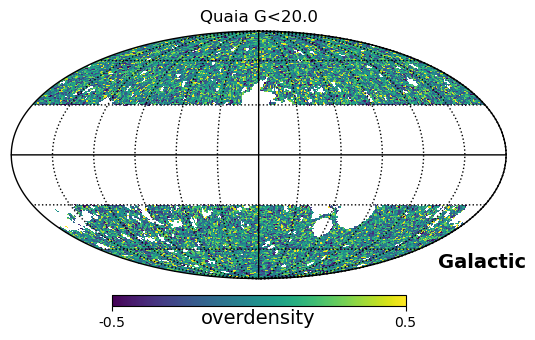

In [4]:
# plot
fig = plt.figure(figsize=(12,3))
hp.mollview(overdensity_map, coord=['C','G'], min=-0.5, max=0.5, badcolor='w', fig=fig, sub=(1,2,1),
            unit='overdensity', title=f'Quaia G<{d.maglim}')
hp.graticule()

In [5]:
# a few different regularization values
Wmasks = np.linspace(0, 1, 11)
Lambdas = Wmasks.copy()

In [6]:
# map to fit: set masked pixels to 0
map_to_fit = overdensity_map.copy()
idx_masked = np.isnan(map_to_fit)
map_to_fit[idx_masked] = 0.

#### measure dipole

In [7]:
# covariance matrices:
# Lambda method: Cinv is the completeness in each pixel
Cinv_Lambda = d.selfunc
# Wmask method: completeness in each _data_ pixel, and Wmask in the masked pixels
Cinv_Wmask = Cinv_Lambda.copy()
# (need to assign Wmask in the for loop below)

In [9]:
# Wmask: what we've been doing
comps_Wmasks = np.empty((len(Wmasks),3))
comps_Lambdas = np.empty_like(comps_Wmasks)
for i in range(len(Wmasks)):
    Cinv_Wmask[idx_masked] = Wmasks[i]
    comps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv_Wmask, fit_zeros=True, Lambda=0)
    comps_Wmasks[i] = comps[1:]
    comps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv_Lambda, fit_zeros=True, Lambda=Lambdas[i])
    comps_Lambdas[i] = comps[1:]